In [1]:
import os
import getpass

from datasets import load_dataset, DatasetDict
from huggingface_hub import login
from transformers import AutoTokenizer
from dotenv import load_dotenv
import matplotlib.pyplot as plt


## Create Chunked Dataset

In [2]:

load_dotenv('.envrc')
if 'HF_TOKEN' in os.environ:
    login(token=os.environ['HF_TOKEN'])
else:
    login(token=getpass.getpass('Huggingface token: '))

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [3]:
# DATASET_REPO = 'roneneldan/TinyStories'
# STORY_KEY = 'text'
DATASET_REPO = 'SimpleStories/SimpleStories'
STORY_KEY = 'story'

CHUNK_LENGTH = 64

TOKENIZER_MODEL = 'SimpleStories/SimpleStories-35M'
TRAIN_SPLIT_PERCENTAGE = 4

In [4]:

dataset = load_dataset(DATASET_REPO, split='train')
print('Total rows:', len(dataset))


Total rows: 2115696


In [5]:
# tokenize the dataset  
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_MODEL)
tokenizer.pad_token = tokenizer.eos_token
def tokenize_function(examples):
    return tokenizer(examples[STORY_KEY], truncation=False, padding='do_not_pad')
tokenized_dataset = dataset.map(tokenize_function, batched=True, remove_columns=dataset.column_names).select_columns(['input_ids'])

tokenized_dataset

Dataset({
    features: ['input_ids'],
    num_rows: 2115696
})

In [6]:

train_dataset, test_dataset = tokenized_dataset.train_test_split(
    test_size=TRAIN_SPLIT_PERCENTAGE / 100,
    seed=42,
).values()

def chunk_dataset_with_map(dataset, token_column='input_ids', chunk_length=CHUNK_LENGTH):
    """
    Memory-efficient version using dataset.map() and batched processing.
    """
    
    def chunk_batch(batch):
        chunked_batch = {col: [] for col in batch.keys()}
        
        for i in range(len(batch[token_column])):
            tokens = batch[token_column][i]
            token_count = len(tokens)
            num_chunks = token_count // chunk_length
            
            for chunk_idx in range(num_chunks):
                start_idx = chunk_idx * chunk_length
                end_idx = start_idx + chunk_length
                chunk_tokens = tokens[start_idx:end_idx]
                
                # Add chunk to batch
                for col in batch.keys():
                    if col == token_column:
                        chunked_batch[col].append(chunk_tokens)
                    else:
                        chunked_batch[col].append(batch[col][i])
        
        return chunked_batch
    
    # Use map with batched=True for memory efficiency
    chunked_dataset = dataset.map(
        chunk_batch,
        batched=True,
        remove_columns=dataset.column_names,  # Remove original columns
        batch_size=1000,  # Adjust based on your memory constraints
    )
    
    return chunked_dataset
chunked_dataset_train = chunk_dataset_with_map(train_dataset, chunk_length=CHUNK_LENGTH)
chunked_dataset_test = chunk_dataset_with_map(test_dataset, chunk_length=CHUNK_LENGTH)

In [ ]:
split_dataset = DatasetDict({
    'train': chunked_dataset_train,
    'test': chunked_dataset_test
})
split_dataset.push_to_hub(f"MikiV/{DATASET_REPO.replace('/', '-')}-chunked-{CHUNK_LENGTH}", private=True)


Uploading the dataset shards:   0%|          | 0/5 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

Processing Files (0 / 0): |          |  0.00B /  0.00B            

New Data Upload: |          |  0.00B /  0.00B            

Creating parquet from Arrow format:   0%|          | 0/5 [00:00<?, ?ba/s]

## Dataset Exploration

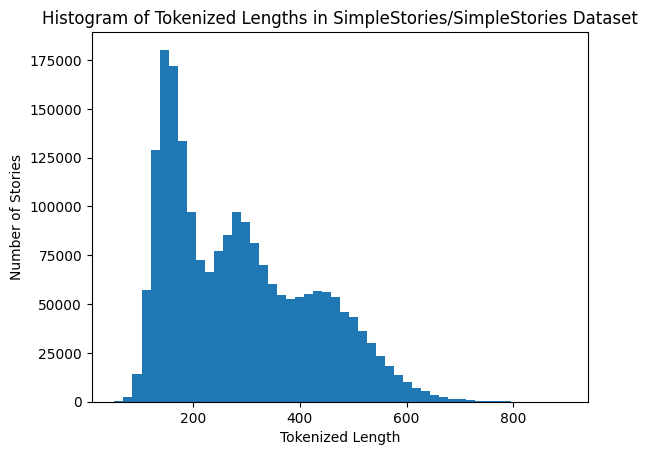

In [ ]:
# Historgram of tokenized lengths
lengths = [len(x) for x in tokenized_dataset['input_ids']]
plt.hist(lengths, bins=50)
plt.xlabel('Tokenized Length')
plt.ylabel('Number of Stories')
plt.title(f'Histogram of Tokenized Lengths in {DATASET_REPO} Dataset')
plt.show()

In [ ]:
total_tokens_train = len(chunked_dataset_train)*CHUNK_LENGTH/1e6
total_tokens_test = len(chunked_dataset_test)*CHUNK_LENGTH/1e6
total_tokens_original = sum(lengths)/1e6
print(f"Total available tokens = {total_tokens_original}M tokens")
print(f"Total tokens in chunked dataset (train) = {total_tokens_train}M tokens")
print(f"Total tokens in chunked dataset (test) = {total_tokens_test}M tokens")
print(f"We are left with {(total_tokens_train + total_tokens_test)/total_tokens_original * 100}% of the original tokens (train)")

Total available tokens = 608.617592M tokens
Total tokens in chunked dataset (train) = 520.93344M tokens
Total tokens in chunked dataset (test) = 21.734464M tokens
We are left with 89.16401877519178% of the original tokens (train)


In [ ]:
for thresh in [64, 128, 256, 512]:
    x = sum(l >= thresh for l in lengths) / len(lengths) * 100
    print(f"{x}% of stories are at least {thresh} tokens")

99.9950370941761% of stories are at least 64 tokens
94.04508020055812% of stories are at least 128 tokens
52.60907049027838% of stories are at least 256 tokens
7.031728565918733% of stories are at least 512 tokens


In [ ]:
tokenizer.get_vocab()

{'##ix': 1251,
 '##ross': 1215,
 'renewed': 3197,
 'wild': 1567,
 'classmates': 3875,
 'fact': 3868,
 'park': 1052,
 '##ider': 3433,
 'alm': 2166,
 'stud': 1834,
 '##sion': 1356,
 'bake': 3208,
 'mural': 2901,
 'picture': 2318,
 'shouted': 608,
 '##ine': 968,
 'surrounded': 1665,
 'spaces': 1829,
 'daughter': 2545,
 'add': 3869,
 '##bb': 628,
 'coat': 3132,
 'gems': 2634,
 'cre': 1563,
 'frag': 3474,
 'scent': 2903,
 'fur': 2184,
 'spread': 1484,
 'chuck': 2289,
 'discovered': 1077,
 '##anc': 1411,
 'gi': 468,
 'swayed': 2639,
 '##eet': 985,
 'faced': 1346,
 'si': 3207,
 'popped': 3400,
 'storm': 769,
 'watered': 2924,
 '##ung': 1220,
 'warm': 493,
 'recall': 2497,
 'loo': 226,
 ')': 10,
 'saying': 1929,
 'hummed': 3859,
 'losing': 2619,
 'sent': 2373,
 '##own': 382,
 'vis': 1168,
 'astrona': 3297,
 'believe': 1421,
 '##ey': 518,
 'taught': 1743,
 '2': 19,
 '##ilt': 1163,
 'declared': 1884,
 'chees': 3380,
 'thinking': 1003,
 '##sp': 1105,
 'carefully': 1498,
 'pul': 3300,
 'something'

In [ ]:
# Ove chunked dataset, find the most common tokens and what percentage of the dataset they cover
from collections import Counter
all_tokens = [token for chunk in chunked_dataset['input_ids'] for token in chunk]
token_counts = Counter(all_tokens)
total_tokens = len(all_tokens)
most_common = token_counts.most_common(20)
for token, count in most_common:
    print(f"Token: {token} ({tokenizer.decode([token])}), Count: {count}, Percentage: {count/total_tokens*100:.2f}%")

NameError: name 'chunked_dataset' is not defined